In [1]:
from preprocessing import *
import preprocessing as prp
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from usad import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from postprocessing import *
import plotly.graph_objects as go
#from usad_conv import *

import warnings
warnings.filterwarnings('ignore')

# Dataset Preparation

In [2]:
dataframe = pd.read_csv(r"/home/medoro/Unsupervised_Anomaly_Detection_thesis/data/train.csv")
dataframe.shape

(1749494, 57)

In [3]:
df=dataframe[['building_id','primary_use', 'timestamp', 'meter_reading', 'sea_level_pressure', 'is_holiday','anomaly']]
df

,building_id,primary_use,timestamp,meter_reading,sea_level_pressure,is_holiday,anomaly
0,1,Education,2016-01-01 00:00:00,NaN,967.2,1,0
1,32,Office,2016-01-01 00:00:00,NaN,967.2,1,0
2,41,Office,2016-01-01 00:00:00,NaN,967.2,1,0
3,55,Office,2016-01-01 00:00:00,NaN,967.2,1,0
4,69,Parking,2016-01-01 00:00:00,NaN,967.2,1,0
...,...,...,...,...,...,...,...
1749489,1316,Entertainment/public assembly,2016-12-31 23:00:00,38.844,967.2,0,0
1749490,1318,Entertainment/public assembly,2016-12-31 23:00:00,202.893,967.2,0,0
1749491,1319,Entertainment/public assembly,2016-12-31 23:00:00,NaN,967.2,0,0
1749492,1323,Office,2016-12-31 23:00:00,172.000,967.2,0,0


In [4]:
imputed_df = impute_nulls(df)
imputed_df

,building_id,primary_use,timestamp,meter_reading,sea_level_pressure,is_holiday,anomaly
0,1,Education,2016-01-01 00:00:00,31.477940,967.2,1,0
200,1,Education,2016-01-01 01:00:00,29.582970,1019.4,1,0
398,1,Education,2016-01-01 02:00:00,28.635485,1018.8,1,0
597,1,Education,2016-01-01 03:00:00,28.161742,1018.1,1,0
796,1,Education,2016-01-01 04:00:00,27.924871,1019.0,1,0
...,...,...,...,...,...,...,...
1748693,1353,Religious worship,2016-12-31 19:00:00,2.425000,967.2,0,0
1748893,1353,Religious worship,2016-12-31 20:00:00,2.450000,967.2,0,0
1749093,1353,Religious worship,2016-12-31 21:00:00,2.425000,967.2,0,0
1749293,1353,Religious worship,2016-12-31 22:00:00,2.450000,967.2,0,0


Now that we have imputed the missing values for the column containing the energy consumption measurements, we can procees by adding a couple of features more and further imputing the missing dates for each timeseries in the dataset.

In [5]:
df = add_trigonometric_features(imputed_df)
df

,building_id,primary_use,timestamp,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x
0,1,Education,2016-01-01 00:00:00,31.477940,967.2,1,0,4,-0.433884,-0.900969
200,1,Education,2016-01-01 01:00:00,29.582970,1019.4,1,0,4,-0.433884,-0.900969
398,1,Education,2016-01-01 02:00:00,28.635485,1018.8,1,0,4,-0.433884,-0.900969
597,1,Education,2016-01-01 03:00:00,28.161742,1018.1,1,0,4,-0.433884,-0.900969
796,1,Education,2016-01-01 04:00:00,27.924871,1019.0,1,0,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...
1748693,1353,Religious worship,2016-12-31 19:00:00,2.425000,967.2,0,0,5,-0.974928,-0.222521
1748893,1353,Religious worship,2016-12-31 20:00:00,2.450000,967.2,0,0,5,-0.974928,-0.222521
1749093,1353,Religious worship,2016-12-31 21:00:00,2.425000,967.2,0,0,5,-0.974928,-0.222521
1749293,1353,Religious worship,2016-12-31 22:00:00,2.450000,967.2,0,0,5,-0.974928,-0.222521


In [6]:
dfs_dict = impute_missing_dates(df)

In [7]:
dfs_dict

{1:                      building_id primary_use  meter_reading  \
 2016-01-01 00:00:00            1   Education      31.477940   
 2016-01-01 01:00:00            1   Education      29.582970   
 2016-01-01 02:00:00            1   Education      28.635485   
 2016-01-01 03:00:00            1   Education      28.161742   
 2016-01-01 04:00:00            1   Education      27.924871   
 ...                          ...         ...            ...   
 2016-12-31 19:00:00            1   Education      20.006000   
 2016-12-31 20:00:00            1   Education      15.364000   
 2016-12-31 21:00:00            1   Education      15.685000   
 2016-12-31 22:00:00            1   Education      15.925000   
 2016-12-31 23:00:00            1   Education      14.964000   
 
                      sea_level_pressure  is_holiday  anomaly  weekday  \
 2016-01-01 00:00:00               967.2           1        0        4   
 2016-01-01 01:00:00              1019.4           1        0        4   
 2016

In [8]:
df1 = pd.concat(dfs_dict.values())
df1

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x
2016-01-01 00:00:00,1,Education,31.477940,967.2,1,0,4,-0.433884,-0.900969
2016-01-01 01:00:00,1,Education,29.582970,1019.4,1,0,4,-0.433884,-0.900969
2016-01-01 02:00:00,1,Education,28.635485,1018.8,1,0,4,-0.433884,-0.900969
2016-01-01 03:00:00,1,Education,28.161742,1018.1,1,0,4,-0.433884,-0.900969
2016-01-01 04:00:00,1,Education,27.924871,1019.0,1,0,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1353,Religious worship,2.425000,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 20:00:00,1353,Religious worship,2.450000,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 21:00:00,1353,Religious worship,2.425000,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 22:00:00,1353,Religious worship,2.450000,967.2,0,0,5,-0.974928,-0.222521


Let's now obtain the train and validation set. We are going to split the dataset into 2 sets, according to the building id.

In [9]:
dfs_train, dfs_val, dfs_test = train_val_test_split(df1)
train = pd.concat(dfs_train.values())

In [10]:
val = pd.concat(dfs_val.values())

In [11]:
test = pd.concat(dfs_test.values())

In [12]:
train

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x
2016-01-01 00:00:00,1,Education,31.477940,967.2,1,0,4,-0.433884,-0.900969
2016-01-01 01:00:00,1,Education,29.582970,1019.4,1,0,4,-0.433884,-0.900969
2016-01-01 02:00:00,1,Education,28.635485,1018.8,1,0,4,-0.433884,-0.900969
2016-01-01 03:00:00,1,Education,28.161742,1018.1,1,0,4,-0.433884,-0.900969
2016-01-01 04:00:00,1,Education,27.924871,1019.0,1,0,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1238,Office,54.900000,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 20:00:00,1238,Office,56.000000,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 21:00:00,1238,Office,66.400000,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 22:00:00,1238,Office,67.100000,967.2,0,0,5,-0.974928,-0.222521


In [13]:
val

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x
2016-01-01 00:00:00,1241,Healthcare,234.180,1018.9,1,0,4,-0.433884,-0.900969
2016-01-01 01:00:00,1241,Healthcare,294.156,1018.4,1,0,4,-0.433884,-0.900969
2016-01-01 02:00:00,1241,Healthcare,354.152,1018.2,1,0,4,-0.433884,-0.900969
2016-01-01 03:00:00,1241,Healthcare,294.121,1018.3,1,0,4,-0.433884,-0.900969
2016-01-01 04:00:00,1241,Healthcare,294.102,1018.2,1,0,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1353,Religious worship,2.425,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 20:00:00,1353,Religious worship,2.450,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 21:00:00,1353,Religious worship,2.425,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 22:00:00,1353,Religious worship,2.450,967.2,0,0,5,-0.974928,-0.222521


In [14]:
test

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x
2016-01-01 00:00:00,69,Parking,19.232375,967.2,1,0,4,-0.433884,-0.900969
2016-01-01 01:00:00,69,Parking,13.457187,1019.4,1,0,4,-0.433884,-0.900969
2016-01-01 02:00:00,69,Parking,10.569594,1018.8,1,0,4,-0.433884,-0.900969
2016-01-01 03:00:00,69,Parking,9.125797,1018.1,1,0,4,-0.433884,-0.900969
2016-01-01 04:00:00,69,Parking,8.403898,1019.0,1,0,4,-0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1319,Entertainment/public assembly,132.040616,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 20:00:00,1319,Entertainment/public assembly,132.040616,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 21:00:00,1319,Entertainment/public assembly,132.040616,967.2,0,0,5,-0.974928,-0.222521
2016-12-31 22:00:00,1319,Entertainment/public assembly,132.040616,967.2,0,0,5,-0.974928,-0.222521


# Training

In [ ]:
train_window = 72

In [ ]:
X_train, y_train = create_train_eval_sequences(train, train_window)

In [ ]:
X_train.shape, y_train.shape

In [19]:
BATCH_SIZE =  128
N_EPOCHS = 40
hidden_size = 1/8

In [21]:
w_size = X_train.shape[1] * X_train.shape[2]
z_size = w_size * hidden_size #X_train.shape[1] * hidden_size 
w_size, z_size

(72, 9.0)

In [22]:
z_size = int(z_size)

In [23]:
z_size

9

In [24]:
import torch.utils.data as data_utils

In [25]:
train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(X_train).float().view(([X_train.shape[0], w_size]))), batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)

In [26]:
X_val, y_val = create_train_eval_sequences(val, train_window)

In [27]:
X_val.shape, y_val.shape

((287496, 72, 1), (287496, 72))

In [28]:
val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(torch.from_numpy(X_val).float().view(([X_val.shape[0],w_size]))) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [29]:
device = get_default_device()
device

device(type='cuda')

In [30]:
%export CUDA_VISIBLE_DEVICES=2

In [31]:
model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [32]:
N_EPOCHS = 50

In [34]:
history = training(N_EPOCHS,model,train_loader,val_loader) #2.15 min a epoch ---> 7/11% gpu (uni/multi) #Conv_autoencoder: 2.45 min --> 22% gpu

Epoch [0], val_loss1: 0.0018, val_loss2: 0.0017
Epoch [1], val_loss1: 0.0228, val_loss2: -0.0056
Epoch [2], val_loss1: 0.0188, val_loss2: -0.0108
Epoch [3], val_loss1: 0.0192, val_loss2: -0.0132
Epoch [4], val_loss1: 0.0172, val_loss2: -0.0131
Epoch [5], val_loss1: 0.0155, val_loss2: -0.0124
Epoch [6], val_loss1: 0.0176, val_loss2: -0.0146
Epoch [7], val_loss1: 0.0200, val_loss2: -0.0169
Epoch [8], val_loss1: 0.0267, val_loss2: -0.0231
Epoch [9], val_loss1: 0.0209, val_loss2: -0.0181
Epoch [10], val_loss1: 0.0238, val_loss2: -0.0211
Epoch [11], val_loss1: 0.0253, val_loss2: -0.0228
Epoch [12], val_loss1: 0.0262, val_loss2: -0.0237
Epoch [13], val_loss1: 0.0249, val_loss2: -0.0226
Epoch [14], val_loss1: 0.0337, val_loss2: -0.0303
Epoch [15], val_loss1: 0.0513, val_loss2: -0.0450
Epoch [16], val_loss1: 0.0666, val_loss2: -0.0491
Epoch [17], val_loss1: 0.0511, val_loss2: -0.0435
Epoch [18], val_loss1: 0.0490, val_loss2: -0.0429
Epoch [19], val_loss1: 0.0513, val_loss2: -0.0459
Epoch [20],

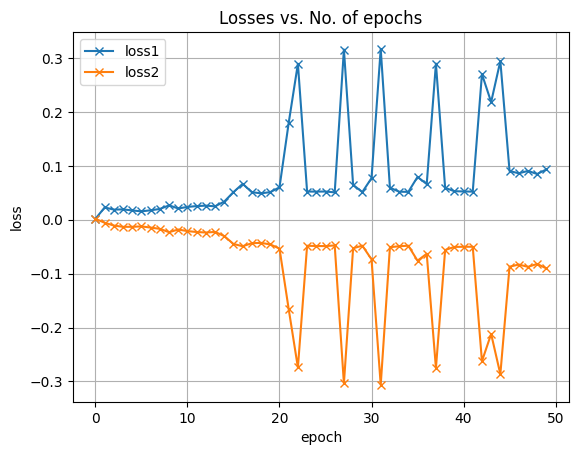

In [35]:
plot_history(history)

In [36]:
print(model)

UsadModel(
  (encoder): Encoder(
    (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (conv2): Conv1d(32, 16, kernel_size=(7,), stride=(2,), padding=(3,))
    (conv3): Conv1d(16, 8, kernel_size=(7,), stride=(2,), padding=(3,))
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder1): Decoder(
    (conv1): ConvTranspose1d(8, 16, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (conv3): ConvTranspose1d(16, 32, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (conv4): ConvTranspose1d(32, 1, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (sigmoid): Sigmoid()
  )
  (decoder2): Decoder(
    (conv1): ConvTranspose1d(8, 16, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (conv3): ConvTranspose1d(16, 32, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (co

In [33]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "/home/medoro/Unsupervised_Anomaly_Detection_thesis/checkpoints/model_100epochs_univariate.pth")

# Testing the model

In [33]:
checkpoint = torch.load("/home/medoro/Unsupervised_Anomaly_Detection_thesis/checkpoints/model_100epochs_univariate.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [34]:
X_test, y_test = create_train_eval_sequences(test, train_window)

In [36]:
X_test.shape, y_test.shape

((331056, 72, 1), (331056, 72))

In [35]:
X_test, y_test = create_test_sequences(test, train_window) #creo sequenze non overlappate

In [36]:
X_test.shape, y_test.shape #non-overlapping

((4636, 72, 1), (4636, 72))

In [37]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(X_test).float().view(([X_test.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [38]:
w1_non_overl, w2_non_overl = reconstruction(model, test_loader)

In [39]:
w1_non_overl

[tensor([[0.1968, 0.1894, 0.1810,  ..., 0.1857, 0.1890, 0.1910],
         [0.1607, 0.1537, 0.1482,  ..., 0.1793, 0.1825, 0.1834],
         [0.1607, 0.1537, 0.1482,  ..., 0.1793, 0.1825, 0.1834],
         ...,
         [0.4777, 0.4695, 0.4628,  ..., 0.4798, 0.4820, 0.4779],
         [0.4777, 0.4695, 0.4628,  ..., 0.4798, 0.4820, 0.4779],
         [0.4777, 0.4695, 0.4628,  ..., 0.4798, 0.4820, 0.4779]],
        device='cuda:0'),
 tensor([[0.4777, 0.4695, 0.4628,  ..., 0.4798, 0.4820, 0.4779],
         [0.4777, 0.4695, 0.4628,  ..., 0.4798, 0.4820, 0.4779],
         [0.4777, 0.4695, 0.4628,  ..., 0.4798, 0.4820, 0.4779],
         ...,
         [0.5425, 0.5274, 0.5147,  ..., 0.5181, 0.5091, 0.4970],
         [0.4885, 0.4744, 0.4666,  ..., 0.6134, 0.6018, 0.5833],
         [0.5382, 0.5244, 0.5117,  ..., 0.5546, 0.5436, 0.5311]],
        device='cuda:0'),
 tensor([[0.5322, 0.5247, 0.5181,  ..., 0.5918, 0.5864, 0.5748],
         [0.5402, 0.5248, 0.5122,  ..., 0.5645, 0.5513, 0.5350],
        

In [40]:
len(w1_non_overl), w1_non_overl[0].size(), w1_non_overl[-1].size()

(37, torch.Size([128, 72]), torch.Size([28, 72]))

In [42]:
36*128 + 28

4636

Now that we have our results, given that the input consisted in non overlapping windows, we can just concatenate the values, into creating a single list of reconstructed values, and then perform anomaly detection as usual, by considering the difference with respect to the ground truth.

In [46]:
# Operations to do for w1 (output of the first autoencoder)
reshaped_w1 = [torch.flatten(w1_el) for w1_el in w1_non_overl]

In [48]:
len(reshaped_w1), reshaped_w1[0].size(), reshaped_w1[-1].size()

(37, torch.Size([9216]), torch.Size([2016]))

In [53]:
# Per i primi 36 tensori, che hanno stessa size, possiamo usare stack per ottenere un unico tensore di 36 * 9216 = 331776 elementi
stacked = torch.stack(reshaped_w1[:-1]).flatten()
stacked.shape

torch.Size([331776])

In [54]:
stacked_array = stacked.cpu().numpy()
stacked_array

array([0.19683616, 0.18942076, 0.1809741 , ..., 0.01304521, 0.01465181,
       0.01794523], dtype=float32)

In [55]:
last_array = reshaped_w1[-1].cpu().numpy()
last_array

array([0.01235232, 0.01254609, 0.0114684 , ..., 0.34629384, 0.34952238,
       0.34775195], dtype=float32)

In [56]:
total = np.concatenate([stacked_array, last_array])

In [57]:
len(total)

333792

In [58]:
# SAME for w2
reshaped_w2 = [torch.flatten(w2_el) for w2_el in w2_non_overl]
stacked2 = torch.stack(reshaped_w2[:-1]).flatten()
stacked_array2 = stacked2.cpu().numpy()
last_array2 = reshaped_w2[-1].cpu().numpy()
total2 = np.concatenate([stacked_array2, last_array2])
len(total2)

333792

In [59]:
total2

array([7.9809380e-13, 1.6775605e-13, 6.6625863e-14, ..., 1.6939133e-13,
       8.7521272e-14, 1.3343185e-13], dtype=float32)

Now we need to create the dataset to perform anomaly detection

In [60]:
scaler = MinMaxScaler(feature_range=(0,1))

In [61]:
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading']]=scaler.fit_transform(gdf[['meter_reading']])
  dfs_dict_1[building_id] = gdf
predicted_df_test = pd.concat(dfs_dict_1.values())

In [62]:
predicted_df_test['reconstruction'] = total

In [63]:
predicted_df_test['reconstruction2'] = total2

In [64]:
predicted_df_test

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x,reconstruction,reconstruction2
2016-01-01 00:00:00,69,Parking,0.350417,967.2,1,0,4,-0.433884,-0.900969,0.196836,7.980938e-13
2016-01-01 01:00:00,69,Parking,0.244752,1019.4,1,0,4,-0.433884,-0.900969,0.189421,1.677561e-13
2016-01-01 02:00:00,69,Parking,0.191920,1018.8,1,0,4,-0.433884,-0.900969,0.180974,6.662586e-14
2016-01-01 03:00:00,69,Parking,0.165504,1018.1,1,0,4,-0.433884,-0.900969,0.172363,2.767322e-14
2016-01-01 04:00:00,69,Parking,0.152296,1019.0,1,0,4,-0.433884,-0.900969,0.163928,2.421226e-14
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.327820,2.330908e-12
2016-12-31 20:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.338053,8.881788e-13
2016-12-31 21:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.346294,1.693913e-13
2016-12-31 22:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.349522,8.752127e-14


In [65]:
predicted_df_test.reconstruction2.min(), predicted_df_test.reconstruction2.max()

(1.3288858e-28, 3.4143934e-09)

In [66]:
predicted_df_test.reconstruction.min(), predicted_df_test.reconstruction.max()

(0.0009392081, 0.94176245)

In [67]:
predicted_df_test['relative_loss'] = np.abs((predicted_df_test['reconstruction']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction'])

In [68]:
predicted_df_test['relative_loss2'] = np.abs((predicted_df_test['reconstruction2']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction2'])

In [69]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold'].values)
print(thresholds.shape)
predicted_df_test['threshold']= thresholds

(333792,)


In [70]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss2'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold2']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold2'].values)
print(thresholds.shape)
predicted_df_test['threshold2']= thresholds

(333792,)


In [71]:
predicted_df_test['predicted_anomaly'] = predicted_df_test['relative_loss'] > predicted_df_test['threshold']
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(False,0)
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(True,1)

/tmp/ipykernel_19875/2648773490.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(True,1)


In [72]:
predicted_df_test['predicted_anomaly2'] = predicted_df_test['relative_loss2'] > predicted_df_test['threshold2']
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(False,0)
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(True,1)

/tmp/ipykernel_19875/3307754308.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(True,1)


In [73]:
predicted_df_test.index.names=['timestamp']
predicted_df_test= predicted_df_test.reset_index()

In [74]:
predicted_df_test.predicted_anomaly.unique()

array([1, 0])

In [75]:
predicted_df_test.predicted_anomaly2.unique()

array([0, 1])

In [76]:
predicted_anomalies = predicted_df_test.loc[predicted_df_test['predicted_anomaly'] == 1]
predicted_anomalies2 = predicted_df_test.loc[predicted_df_test['predicted_anomaly2'] == 1]
true_anomalies = predicted_df_test.loc[predicted_df_test['anomaly'] == 1]

In [77]:
predicted_df_test = pd.merge(predicted_df_test, df[['timestamp','building_id']], on=['timestamp','building_id'])

In [78]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly']))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    324574
           1       0.25      0.51      0.34      7767

    accuracy                           0.95    332341
   macro avg       0.62      0.74      0.66    332341
weighted avg       0.97      0.95      0.96    332341



In [79]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2']))

              precision    recall  f1-score   support

           0       0.97      0.81      0.89    324574
           1       0.02      0.12      0.03      7767

    accuracy                           0.80    332341
   macro avg       0.50      0.47      0.46    332341
weighted avg       0.95      0.80      0.87    332341



In [81]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly'])

0.7379442690263885

In [80]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2'])

0.46765191928245164

In [82]:
predicted_df_test.building_id.unique()

array([  69,   79,  119,  139,  144,  149,  159,  174,  254,  439,  534,
        729,  739,  844,  879,  884,  889,  894,  909,  914,  919,  924,
        929,  969,  974,  994, 1074, 1219, 1234, 1239, 1249, 1259, 1264,
       1279, 1284, 1304, 1309, 1319])

In [83]:
visualizations = predicted_df_test[predicted_df_test.building_id == 1304]
visualizations

,timestamp,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x,reconstruction,reconstruction2,relative_loss,relative_loss2,threshold,threshold2,predicted_anomaly,predicted_anomaly2
305989,2016-01-01 00:00:00,1304,Office,0.415880,1018.9,1,0,4,-0.433884,-0.900969,0.427684,3.474548e-15,0.027598,1.196934e+14,0.19302,1.324253e+15,0,0
305990,2016-01-01 01:00:00,1304,Office,0.417195,1018.4,1,0,4,-0.433884,-0.900969,0.419955,5.316392e-16,0.006573,7.847327e+14,0.19302,1.324253e+15,0,0
305991,2016-01-01 02:00:00,1304,Office,0.435985,1018.2,1,0,4,-0.433884,-0.900969,0.415534,1.768832e-16,0.049216,2.464816e+15,0.19302,1.324253e+15,0,1
305992,2016-01-01 03:00:00,1304,Office,0.443658,1018.3,1,0,4,-0.433884,-0.900969,0.415062,6.162252e-17,0.068896,7.199608e+15,0.19302,1.324253e+15,0,1
305993,2016-01-01 04:00:00,1304,Office,0.471431,1018.2,1,0,4,-0.433884,-0.900969,0.417972,5.064910e-17,0.127901,9.307784e+15,0.19302,1.324253e+15,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314768,2016-12-31 19:00:00,1304,Office,0.492512,967.2,0,0,5,-0.974928,-0.222521,0.498366,1.712051e-13,0.011746,2.876737e+12,0.19302,1.324253e+15,0,0
314769,2016-12-31 20:00:00,1304,Office,0.479189,967.2,0,0,5,-0.974928,-0.222521,0.499885,5.808341e-14,0.041402,8.250019e+12,0.19302,1.324253e+15,0,0
314770,2016-12-31 21:00:00,1304,Office,0.452989,967.2,0,0,5,-0.974928,-0.222521,0.502350,9.458393e-15,0.098261,4.789279e+13,0.19302,1.324253e+15,0,0
314771,2016-12-31 22:00:00,1304,Office,0.511679,967.2,0,0,5,-0.974928,-0.222521,0.501433,4.646179e-15,0.020435,1.101291e+14,0.19302,1.324253e+15,0,0


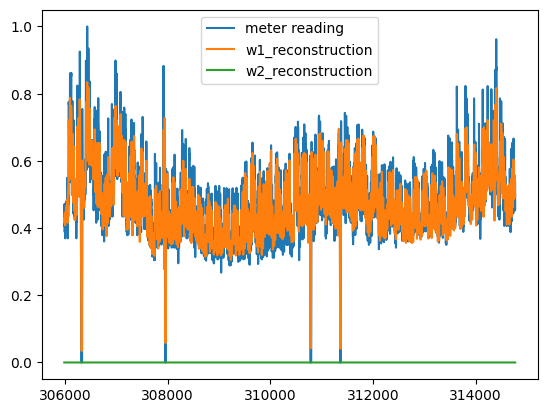

In [84]:
plt.plot(visualizations.meter_reading, label = "meter reading") 
plt.plot(visualizations.reconstruction, label = "w1_reconstruction")
plt.plot(visualizations.reconstruction2, label = "w2_reconstruction")
plt.legend()
plt.show()

# Testing the model (overlapping windows; anomaly score-based)

In [40]:
results=testing(model,test_loader) #Prova con il test set

In [ ]:
results

Let's create the dataset to perform predictions.

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading', 'sea_level_pressure']]=scaler.fit_transform(gdf[['meter_reading', 'sea_level_pressure']])
  dfs_dict_1[building_id] = gdf[train_window:]
predicted_df = pd.concat(dfs_dict_1.values())

In [ ]:
lista = []
for el in results:
  for el2 in el:
    lista.append(el2.cpu().item())
lista

In [ ]:
plt.hist(lista, bins=50)
plt.xlabel("Anomaly score")
plt.ylabel("No of samples")
plt.show()

In [ ]:
predicted_df['anomaly_score'] = lista

In [ ]:
predicted_df

In [ ]:
predicted_df.anomaly_score.min(), predicted_df.anomaly_score.max() 

In [ ]:
perc = 90
threshold = (np.percentile(predicted_df.anomaly_score.values, perc))

In [ ]:
threshold

In [ ]:
predicted_df['threshold'] = threshold

In [ ]:
predicted_df['predicted_anomaly'] = predicted_df.anomaly_score > predicted_df['threshold']
predicted_df['predicted_anomaly']=predicted_df['predicted_anomaly'].replace(False,0)
predicted_df['predicted_anomaly']=predicted_df['predicted_anomaly'].replace(True,1)

In [ ]:
predicted_df.predicted_anomaly.unique()

In [ ]:
len(predicted_df[predicted_df.predicted_anomaly == 1])/len(predicted_df)

In [ ]:
predicted_df.index.names=['timestamp']
predicted_df= predicted_df.reset_index()

In [ ]:
predicted_df = pd.merge(predicted_df, df[['timestamp','building_id']], on=['timestamp','building_id'])

In [ ]:
print(classification_report(predicted_df.anomaly, predicted_df.predicted_anomaly))

In [ ]:
roc_auc_score(predicted_df['anomaly'], predicted_df['predicted_anomaly'])

# Testing the model (overlapping windows; reconstruction-based)

In [66]:
results, w1, w2 = testing_prova(model, test_loader)

In [68]:
w1

[tensor([[[0.4273],
          [0.4273],
          [0.4273],
          ...,
          [0.4273],
          [0.4273],
          [0.4273]],
 
         [[0.4273],
          [0.4273],
          [0.4273],
          ...,
          [0.4273],
          [0.4273],
          [0.4273]],
 
         [[0.4273],
          [0.4273],
          [0.4273],
          ...,
          [0.4273],
          [0.4273],
          [0.4273]],
 
         ...,
 
         [[0.4273],
          [0.4273],
          [0.4273],
          ...,
          [0.4273],
          [0.4273],
          [0.4273]],
 
         [[0.4273],
          [0.4273],
          [0.4273],
          ...,
          [0.4273],
          [0.4273],
          [0.4273]],
 
         [[0.4273],
          [0.4273],
          [0.4273],
          ...,
          [0.4273],
          [0.4273],
          [0.4273]]], device='cuda:0'),
 tensor([[[0.4273],
          [0.4273],
          [0.4273],
          ...,
          [0.4273],
          [0.4273],
          [0.4273]],
 
 

In [69]:
w2

[tensor([[[0.4485],
          [0.4485],
          [0.4485],
          ...,
          [0.4485],
          [0.4485],
          [0.4485]],
 
         [[0.4485],
          [0.4485],
          [0.4485],
          ...,
          [0.4485],
          [0.4485],
          [0.4485]],
 
         [[0.0000],
          [1.0000],
          [0.0000],
          ...,
          [0.4485],
          [0.4485],
          [0.4485]],
 
         ...,
 
         [[0.0000],
          [1.0000],
          [0.0000],
          ...,
          [0.4485],
          [0.4485],
          [0.4485]],
 
         [[0.4485],
          [0.4485],
          [0.4485],
          ...,
          [0.4485],
          [0.4485],
          [0.4485]],
 
         [[0.4485],
          [0.4485],
          [0.4485],
          ...,
          [0.4485],
          [0.4485],
          [0.4485]]], device='cuda:0'),
 tensor([[[0.4485],
          [0.4485],
          [0.4485],
          ...,
          [0.4485],
          [0.4485],
          [0.4485]],
 
 

In [ ]:
# CELLA DA FAR GIRARE SE SI STA USANDO usad_conv
w1_new = [torch.reshape(w1_el, (w1_el.size()[0], w1_el.size()[1])) for w1_el in w1]
w2_new = [torch.reshape(w2_el, (w2_el.size()[0], w2_el.size()[1])) for w2_el in w2]

In [ ]:
padded_w1 = padding_w(w1_new, BATCH_SIZE) # Se si usa usad, non convoluzionale, mettere w1 al posto di w1_new

In [ ]:
padded_w2 = padding_w(w2_new, BATCH_SIZE) # Se si usa usad, non convoluzionale, mettere w2 al posto di w2_new

In [134]:
reconstruction = apply_reconstruction(padded_w1, test.building_id.nunique())

0


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


1


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


2


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


3


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


4


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


5


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


6


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


7


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


8


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


9


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


10


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


11


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


12


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


13


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


14


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


15


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


16


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


17


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


18


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


19


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


20


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


21


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


22


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


23


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


24


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


25


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


26


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


27


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


28


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


29


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


30


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


31


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


32


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


33


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


34


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


35


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


36


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


37


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


In [135]:
reconstruction2 = apply_reconstruction(padded_w2, test.building_id.nunique())

0


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


1


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


2


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


3


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


4


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


5


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


6


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


7


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


8


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


9


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


10


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


11


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


12


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


13


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


14


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


15


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


16


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


17


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


18


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


19


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


20


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


21


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


22


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


23


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


24


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


25


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


26


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


27


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


28


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


29


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


30


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


31


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


32


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


33


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


34


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


35


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


36


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


37


/tmp/ipykernel_23126/1893028571.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  transposed_df = pd.concat([transposed_df, rows], ignore_index = True) #transposed_df.append(rows, ignore_index = True)
/tmp/ipykernel_23126/1893028571.py:17: RuntimeWarning: Mean of empty slice
  media = np.nanmean(retransposed, axis = 0)


## Reconstruction (overlapping; w1,w2-based)

In [136]:
scaler = MinMaxScaler(feature_range=(0,1))

In [137]:
dfs_dict_1 = {}
for building_id, gdf in test.groupby("building_id"):
  gdf[['meter_reading']]=scaler.fit_transform(gdf[['meter_reading']])
  dfs_dict_1[building_id] = gdf
predicted_df_test = pd.concat(dfs_dict_1.values())

In [138]:
predicted_df_test['reconstruction'] = reconstruction

In [139]:
predicted_df_test['reconstruction2'] = reconstruction2

In [140]:
predicted_df_test

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x,reconstruction,reconstruction2
2016-01-01 00:00:00,69,Parking,0.350417,967.2,1,0,4,-0.433884,-0.900969,0.427285,0.448516
2016-01-01 01:00:00,69,Parking,0.244752,1019.4,1,0,4,-0.433884,-0.900969,0.427285,0.448516
2016-01-01 02:00:00,69,Parking,0.191920,1018.8,1,0,4,-0.433884,-0.900969,0.427285,0.299010
2016-01-01 03:00:00,69,Parking,0.165504,1018.1,1,0,4,-0.433884,-0.900969,0.427285,0.586387
2016-01-01 04:00:00,69,Parking,0.152296,1019.0,1,0,4,-0.433884,-0.900969,0.427285,0.358812
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.586387
2016-12-31 20:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.448516
2016-12-31 21:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.448516
2016-12-31 22:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.448516


In [141]:
predicted_df_test['reconstruction']=predicted_df_test['reconstruction'].replace(np.nan,0)

In [142]:
predicted_df_test['reconstruction2']=predicted_df_test['reconstruction2'].replace(np.nan,0)

In [143]:
predicted_df_test

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x,reconstruction,reconstruction2
2016-01-01 00:00:00,69,Parking,0.350417,967.2,1,0,4,-0.433884,-0.900969,0.427285,0.448516
2016-01-01 01:00:00,69,Parking,0.244752,1019.4,1,0,4,-0.433884,-0.900969,0.427285,0.448516
2016-01-01 02:00:00,69,Parking,0.191920,1018.8,1,0,4,-0.433884,-0.900969,0.427285,0.299010
2016-01-01 03:00:00,69,Parking,0.165504,1018.1,1,0,4,-0.433884,-0.900969,0.427285,0.586387
2016-01-01 04:00:00,69,Parking,0.152296,1019.0,1,0,4,-0.433884,-0.900969,0.427285,0.358812
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.586387
2016-12-31 20:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.448516
2016-12-31 21:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.448516
2016-12-31 22:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.448516


In [144]:
predicted_df_test.reconstruction2.min(), predicted_df_test.reconstruction2.max()

(0.0, 1.0)

In [145]:
predicted_df_test['relative_loss'] = np.abs((predicted_df_test['reconstruction']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction'])

In [146]:
predicted_df_test['relative_loss2'] = np.abs((predicted_df_test['reconstruction2']-predicted_df_test['meter_reading'])/predicted_df_test['reconstruction2'])

In [147]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold'].values)
print(thresholds.shape)
predicted_df_test['threshold']= thresholds

(333792,)


In [148]:
#calculate threshold on relative loss quartiles but only on val, and in this case per building
thresholds=np.array([])
for building_id, gdf in predicted_df_test.groupby("building_id"):
  val_mre_loss_building= gdf['relative_loss2'].values
  building_threshold = (np.percentile(val_mre_loss_building, 75)) + 1.5 *((np.percentile(val_mre_loss_building, 75))-(np.percentile(val_mre_loss_building, 25)))
  gdf['threshold2']=building_threshold
  thresholds= np.append(thresholds, gdf['threshold2'].values)
print(thresholds.shape)
predicted_df_test['threshold2']= thresholds

(333792,)


In [149]:
predicted_df_test

,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x,reconstruction,reconstruction2,relative_loss,relative_loss2,threshold,threshold2
2016-01-01 00:00:00,69,Parking,0.350417,967.2,1,0,4,-0.433884,-0.900969,0.427285,0.448516,0.179899,0.218719,1.479710,1.617473
2016-01-01 01:00:00,69,Parking,0.244752,1019.4,1,0,4,-0.433884,-0.900969,0.427285,0.448516,0.427192,0.454306,1.479710,1.617473
2016-01-01 02:00:00,69,Parking,0.191920,1018.8,1,0,4,-0.433884,-0.900969,0.427285,0.299010,0.550838,0.358148,1.479710,1.617473
2016-01-01 03:00:00,69,Parking,0.165504,1018.1,1,0,4,-0.433884,-0.900969,0.427285,0.586387,0.612661,0.717756,1.479710,1.617473
2016-01-01 04:00:00,69,Parking,0.152296,1019.0,1,0,4,-0.433884,-0.900969,0.427285,0.358812,0.643572,0.575555,1.479710,1.617473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.586387,0.212444,0.426128,0.665155,0.658757
2016-12-31 20:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.448516,0.212444,0.249724,0.665155,0.658757
2016-12-31 21:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.448516,0.212444,0.249724,0.665155,0.658757
2016-12-31 22:00:00,1319,Entertainment/public assembly,0.336511,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.448516,0.212444,0.249724,0.665155,0.658757


In [150]:
predicted_df_test['predicted_anomaly'] = predicted_df_test['relative_loss'] > predicted_df_test['threshold']
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(False,0)
predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(True,1)

/tmp/ipykernel_23126/2648773490.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_df_test['predicted_anomaly']=predicted_df_test['predicted_anomaly'].replace(True,1)


In [151]:
predicted_df_test['predicted_anomaly2'] = predicted_df_test['relative_loss2'] > predicted_df_test['threshold2']
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(False,0)
predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(True,1)

/tmp/ipykernel_23126/3307754308.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  predicted_df_test['predicted_anomaly2']=predicted_df_test['predicted_anomaly2'].replace(True,1)


In [152]:
predicted_df_test.index.names=['timestamp']
predicted_df_test= predicted_df_test.reset_index()

In [153]:
predicted_df_test.predicted_anomaly.unique()

array([0, 1])

In [154]:
predicted_df_test.predicted_anomaly2.unique()

array([0, 1])

In [155]:
predicted_anomalies = predicted_df_test.loc[predicted_df_test['predicted_anomaly'] == 1]
predicted_anomalies2 = predicted_df_test.loc[predicted_df_test['predicted_anomaly2'] == 1]
true_anomalies = predicted_df_test.loc[predicted_df_test['anomaly'] == 1]

In [156]:
predicted_df_test = pd.merge(predicted_df_test, df[['timestamp','building_id']], on=['timestamp','building_id'])

In [157]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly']))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    324574
           1       0.32      0.25      0.28      7767

    accuracy                           0.97    332341
   macro avg       0.65      0.62      0.63    332341
weighted avg       0.97      0.97      0.97    332341



In [158]:
print(classification_report(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2']))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    324574
           1       0.27      0.22      0.24      7767

    accuracy                           0.97    332341
   macro avg       0.62      0.60      0.61    332341
weighted avg       0.96      0.97      0.97    332341



In [159]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly'])

0.6175697532878285

In [160]:
roc_auc_score(predicted_df_test['anomaly'], predicted_df_test['predicted_anomaly2'])

0.6047837737461697

In [121]:
predicted_df_test.building_id.unique()

array([  69,   79,  119,  139,  144,  149,  159,  174,  254,  439,  534,
        729,  739,  844,  879,  884,  889,  894,  909,  914,  919,  924,
        929,  969,  974,  994, 1074, 1219, 1234, 1239, 1249, 1259, 1264,
       1279, 1284, 1304, 1309, 1319])

In [165]:
visualizations = predicted_df_test[predicted_df_test.building_id == 1304]
visualizations

,timestamp,building_id,primary_use,meter_reading,sea_level_pressure,is_holiday,anomaly,weekday,weekday_y,weekday_x,reconstruction,reconstruction2,relative_loss,relative_loss2,threshold,threshold2,predicted_anomaly,predicted_anomaly2
305989,2016-01-01 00:00:00,1304,Office,0.415880,1018.9,1,0,4,-0.433884,-0.900969,0.427285,0.448516,0.026691,0.072762,0.545425,0.683546,0,0
305990,2016-01-01 01:00:00,1304,Office,0.417195,1018.4,1,0,4,-0.433884,-0.900969,0.427285,0.448516,0.023615,0.069832,0.545425,0.683546,0,0
305991,2016-01-01 02:00:00,1304,Office,0.435985,1018.2,1,0,4,-0.433884,-0.900969,0.427285,0.448516,0.020360,0.027939,0.545425,0.683546,0,0
305992,2016-01-01 03:00:00,1304,Office,0.443658,1018.3,1,0,4,-0.433884,-0.900969,0.427285,0.448516,0.038319,0.010830,0.545425,0.683546,0,0
305993,2016-01-01 04:00:00,1304,Office,0.471431,1018.2,1,0,4,-0.433884,-0.900969,0.427285,0.448516,0.103317,0.051091,0.545425,0.683546,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314768,2016-12-31 19:00:00,1304,Office,0.492512,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.336387,0.152655,0.464125,0.545425,0.683546,0,0
314769,2016-12-31 20:00:00,1304,Office,0.479189,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.632344,0.121475,0.242201,0.545425,0.683546,0,0
314770,2016-12-31 21:00:00,1304,Office,0.452989,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.224258,0.060156,1.019947,0.545425,0.683546,0,1
314771,2016-12-31 22:00:00,1304,Office,0.511679,967.2,0,0,5,-0.974928,-0.222521,0.427285,0.000000,0.197513,inf,0.545425,0.683546,0,1


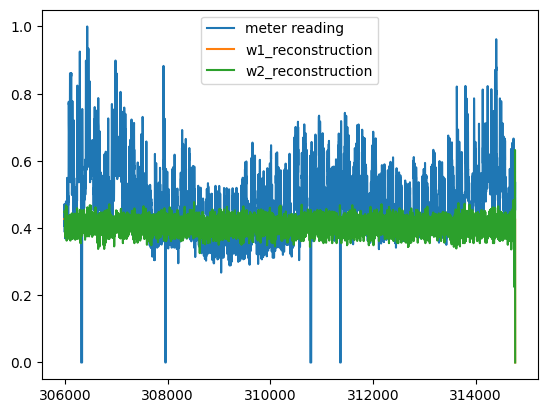

In [166]:
plt.plot(visualizations.meter_reading, label = "meter reading") #predicted_df_test.meter_reading[:8784]
plt.plot(visualizations.reconstruction, label = "w1_reconstruction")
plt.plot(visualizations.reconstruction2, label = "w2_reconstruction")
plt.legend()
plt.show()

In [ ]:
predicted_anomalies = predicted_df_test.loc[predicted_df_test['predicted_anomaly'] == 1]
true_anomalies = predicted_df_test.loc[predicted_df_test['anomaly'] == 1]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=predicted_df_test.index, y=predicted_df_test['meter_reading'], name='meter readings'))
fig.add_trace(go.Scatter(x=predicted_df_test.index, y=predicted_df_test['reconstruction'], name='meter readings reconstructed'))

fig.add_trace(go.Scatter(x=true_anomalies['timestamp'], y=true_anomalies['meter_reading'], mode='markers', marker=dict(color='forestgreen'), name='True_Anomaly'))
fig.update_layout(showlegend=True, title='meter readings predicted and anomalies - val')
fig.show()